# HW2A: Alignment with IBM Model 1


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import math
import matplotlib.pyplot as plt # graphs and figures
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
from collections import Counter
from itertools import product
import tqdm.notebook
import pickle

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data

We'll start out by using a toy dataset. Please see [these slides](https://cal-cs288.github.io/sp20/slides/cs288_sp20_05_statistical_translation_4up.pdf) for a more complete coverage of IBM Model 1, and feel free to check out Philipp Koehn's book _Statistical Machine Translation_. 

In [2]:
aligned_data = [
    (["das", "haus"], ["the", "house"]),
    (["das", "buch"], ["the", "book"]),
    (["ein", "buch"], ["a", "book"]),
]

## Alignment Model

Fill in the code for IBM Model 1 below. A correct implementation should achieve perplexity 4096 on the first iteration and perplexity around 70 by the tenth iteration, for the toy dataset above. Note that we'll be grading you only on the generated `self.translation_probabilities`, so the probability and perplexity functions only exist for you to check the correctness of your own implementation. You may wish to comment them out during implementation and check that `self.translation_probabilities` looks reasonable instead.

In [3]:
class IBMModel1:
    def __init__(self, data, num_iterations=10, epsilon=1.0, compute_perplexity=True):
        self.data = data # aligned corpus as shown above
        self.num_iterations = num_iterations # iterations of expectation-maximization
        self.epsilon = epsilon
        self.compute_perplexity = compute_perplexity
        
        # Preprocess bitext data:
        self.source_words, self.target_words = set(), set()
        for (source,target) in self.data:
            self.source_words.update(source)
            self.target_words.update(target)
        
        # Initialize uniform probabilities:
        self.translation_probs = {(s,t): 1.0/len(self.target_words)
                                  for s,t in product(self.source_words, self.target_words)}
        
    def e_step(self):
        # YOUR SOLUTION HERE
        # - Iterate over paired sentences in the data and compute:
        # - (1) counts, the number of times a source word is translated into a target word,
        #       weighted by alignment probabilities
        # - (2) total, the sum of counts over all possible target words
        # See slide 32 for more information: https://cal-cs288.github.io/sp20/slides/cs288_sp20_05_statistical_translation_4up.pdf
        # BEGIN SOLUTION
        counts = {}
        total = {}
        for source, target in self.data:
            s_total = {}
            for e in target:
                if e not in s_total:
                    s_total[e] = 0
                for f in source:
                    s_total[e] += self.translation_probs[(f,e)]
            for e in target:
                for f in source:
                    # ccounts increment
                    if (f,e) not in counts:
                        counts[(f,e)] = 0
                    counts[(f,e)] += self.translation_probs[(f,e)] / s_total[e]
                    
                    # total increment
                    if f not in total:
                        total[f] = 0
                    total[f] += self.translation_probs[(f,e)] / s_total[e]
        return counts, total
                    
        # END SOLUTION
        
    def m_step(self, counts, total):
        # YOUR SOLUTION HERE
        # - Update self.translation_probs using counts and total
        # BEGIN SOLUTION
        for f in self.source_words:
            for e in self.target_words:
                if (f,e) in counts:
                    self.translation_probs[(f,e)] = counts[(f,e)] / total[f]
                else:
                    self.translation_probs[(f,e)] = 0
        # END SOLUTION
        
    def train(self):
        # Run EM for self.num_iterations:
        for idx in tqdm.tqdm(range(self.num_iterations)):
            if self.compute_perplexity: 
                print("Iteration: {} | Perplexity: {}".format(idx, self.perplexity()))
            counts, total = self.e_step()
            self.m_step(counts, total)
        if self.compute_perplexity:
            print("Iteration: {} | Perplexity: {}".format(self.num_iterations, self.perplexity()))

    def probability(self, source, target):
        # YOUR SOLUTION HERE
        # - Use the normalization trick from lecture to efficiently compute probabilities
        # - We'll use self.epsilon here, which is defined in the initialization
        # BEGIN SOLUTION
        lf = len(source)
        le = len(target)
        alignment = self.get_alignment(source, target)
        norm = self.epsilon / ((lf)**le)
        prob = 1
        for j in range(le):
            ej = target[j]
            faj = source[alignment[j][1]]
            prob *= self.translation_probs[(faj,ej)]
        return norm * prob
        # END SOLUTION
        
    def perplexity(self):
        # YOUR SOLUTION HERE
        # - Iterate over each pair of sentences in the dataset
        # - Call self.probability and compute a sum in log space
        # - Feel free to comment this out while testing your initial model
        # BEGIN SOLUTION
        total = 0
        for source, target in self.data:
            prob = self.probability(source, target)
            total += np.log2(prob)
        # END SOLUTION
        return 2**(-total)
        
    def get_alignment(self, source, target):
        # YOUR SOLUTION HERE
        # - Find the best word alignment for a source, target pair
        # - Output a list of [(source_idx, target_idx)]
        #   For example: (["ein", "buch"], ["a", "book"])
        #   should have an alignment [(0,0), (1,1)]
        # BEGIN SOLUTION
        alignment = []
        for j in range(len(target)):
            e = target[j]
            t_e = []
            for i in range(len(source)):
                f = source[i]
                t_e.append(self.translation_probs[(f,e)])
            align_idx = np.array(t_e).argmax()
            alignment.append((j, align_idx))
        # END SOLUTION
        return alignment

ibm = IBMModel1(aligned_data)
ibm.train()
assert(ibm.get_alignment(["ein", "buch"], ["a", "book"]) == [(0, 0), (1, 1)])
with open("example_alignments.pkl", "wb") as outfile:
    pickle.dump(ibm.translation_probs, outfile, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 10/10 [00:00<00:00, 8893.77it/s]

Iteration: 0 | Perplexity: 262144.0
Iteration: 1 | Perplexity: 4096.0
Iteration: 2 | Perplexity: 1195.183673469387
Iteration: 3 | Perplexity: 479.1500164502666
Iteration: 4 | Perplexity: 251.50638802286775
Iteration: 5 | Perplexity: 162.42851221343935
Iteration: 6 | Perplexity: 121.67417140347465
Iteration: 7 | Perplexity: 100.80834712096922
Iteration: 8 | Perplexity: 89.22475044994033
Iteration: 9 | Perplexity: 82.3880298598886
Iteration: 10 | Perplexity: 78.14240739659961


## Visualization and Analysis

Write code to visualize alignments and rerun the IBM model on a (very slightly larger) toy dataset:

100%|██████████| 10/10 [00:00<00:00, 3015.32it/s]


Iteration: 0 | Perplexity: 1.0421847026626917e+25
Iteration: 1 | Perplexity: 2.461649403887346e+18
Iteration: 2 | Perplexity: 9690679453267620.0
Iteration: 3 | Perplexity: 196121721538615.56
Iteration: 4 | Perplexity: 13637619139003.734
Iteration: 5 | Perplexity: 2175456045115.096
Iteration: 6 | Perplexity: 605493641169.5632
Iteration: 7 | Perplexity: 242897366539.05728
Iteration: 8 | Perplexity: 120784902634.04245
Iteration: 9 | Perplexity: 71371085052.61346
Iteration: 10 | Perplexity: 47676550751.941895


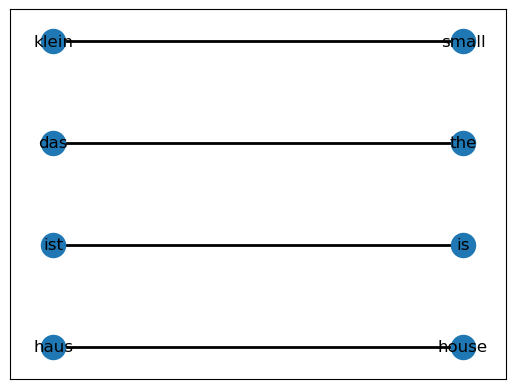

In [10]:
import networkx as nx
from networkx.algorithms import bipartite

def visualize_alignment(alignment, source, target):
    # YOUR SOLUTION HERE
    # BEGIN ALIGNMENT
    source_nodes = set(source)
    target_nodes = set(target)
    edges = []
    for a in alignment:
        i,j = a
        edges.append((target[i], source[j]))
    G = nx.Graph()
    G.add_nodes_from(source_nodes, bipartite=0)
    G.add_nodes_from(target_nodes, bipartite=1)
    G.add_edges_from(edges)
    bipartite.is_bipartite(G)
    nx.draw_networkx(G, pos = nx.drawing.layout.bipartite_layout(G, source_nodes), width = 2)
    # END ALIGNMENT

aligned_data = [
    (['klein', 'ist', 'das', 'haus'], ['the', 'house', 'is', 'small']),
    (['das', 'haus', 'ist', 'ja', 'groß'], ['the', 'house', 'is', 'big']),
    (['das', 'buch', 'ist', 'ja', 'klein'], ['the', 'book', 'is', 'small']),
    (['das', 'haus'], ['the', 'house']),
    (['das', 'buch'], ['the', 'book']),
    (['ein', 'buch'], ['a', 'book'])
]
ibm = IBMModel1(aligned_data)
ibm.train()
alignment = ibm.get_alignment(['klein', 'ist', 'das', 'haus'], ['the', 'house', 'is', 'small'])
visualize_alignment(alignment, ['klein', 'ist', 'das', 'haus'], ['the', 'house', 'is', 'small'])

We'll now run the IBM model on a significantly larger dataset to showcase its failure modes:

In [5]:
!pip install sentencepiece torchtext==0.8.1
import sentencepiece
import torchtext

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 9.9 MB/s eta 0:00:00:00:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.8/776.8 MB 1.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cpu
    Uninstalling torch-1.12.0+cpu:
      Successfully uninstalled torch-1.12.0+cpu
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.0
    Uninstalling torchtext-0.13.0:
      Successfully uninstalled torchtext-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.0+cpu requires torch==1.12.0, but you have torch 1.7.1 which is incompatible.
torchmetrics 0.11.1 requires torch>=1.8.1, but you have torch 1.7.1 which is incompatible.
torchaudio 0.12.0+cpu requires

In [6]:
# Load the Multi30K translation dataset:
extensions = [".de", ".en"]
source_field = torchtext.data.Field(tokenize=lambda x: x)
target_field = torchtext.data.Field(tokenize=lambda x: x)
training_data, validation_data, test_data = torchtext.datasets.Multi30k.splits(
    extensions, [source_field, target_field], root=".")

/opt/conda/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 4.55MB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 1.73MB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 1.47MB/s]
/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [12]:
def preprocess(sentence):
    sentence = sentence.translate(str.maketrans('', '', string.punctuation)) # strip punctuation
    return sentence.strip().lower().split()

aligned_data = []
for example in training_data[:1000]:
    source = preprocess(example.src)
    target = preprocess(example.trg)
    aligned_data.append((source, target))

ibm = IBMModel1(aligned_data, compute_perplexity=False)
ibm.train()
with open("multi30k_alignments.pkl", "wb") as outfile:
    pickle.dump(ibm.translation_probs, outfile, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 10/10 [00:29<00:00,  2.92s/it]


In [13]:
# Making sure the model learned something:
examples = [
    ("hund", "dog"),
    ("hund", "cat"),
    ("ein", "a"),
    ("ein", "the"),
    ("frau", "woman"),
    ("frau", "man"),
]


for example in examples:
    print(str(example) + ": " + str(ibm.translation_probs[example]))

('hund', 'dog'): 0.9884762554018363
('hund', 'cat'): 1.0395276004096572e-16
('ein', 'a'): 0.7245833272409481
('ein', 'the'): 0.0026271205870809678
('frau', 'woman'): 0.9882647016669033
('frau', 'man'): 1.3963388009377444e-07


From this larger dataset: find at least one sentence where the IBM alignment model performs reasonably well, and find another one where it fails catastrophically, and include alignment visualizations for both examples in your report. You may want to consult a [German-English dictionary](https://www.collinsdictionary.com/us/dictionary/english-german) for this part of the problem. Provide a brief explanation for why the alignment model did poorly on the failure case.

Source ['mehrere', 'frauen', 'warten', 'in', 'einer', 'stadt', 'im', 'freien']
Target ['several', 'women', 'wait', 'outside', 'in', 'a', 'city']


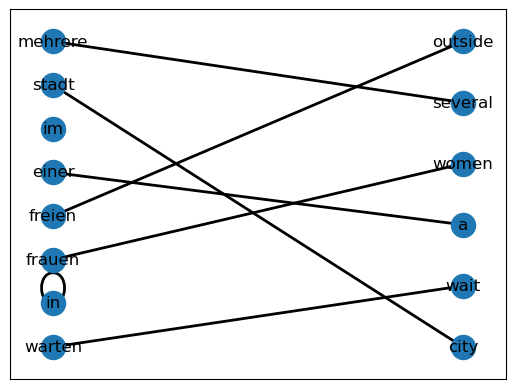

In [44]:
good_idx = 14
example = training_data[good_idx]
source = preprocess(example.src)
target = preprocess(example.trg)
print('Source', source)
print('Target', target)
alignment = ibm.get_alignment(source, target)
visualize_alignment(alignment, source, target)

Source ['eine', 'ballettklasse', 'mit', 'fünf', 'mädchen', 'die', 'nacheinander', 'springen']
Target ['a', 'ballet', 'class', 'of', 'five', 'girls', 'jumping', 'in', 'sequence']


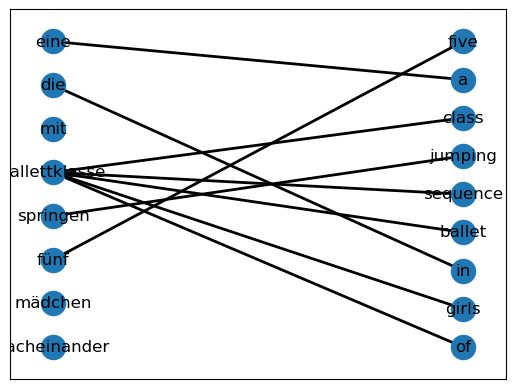

In [33]:
bad_idx = 10
example = training_data[bad_idx]
source = preprocess(example.src)
target = preprocess(example.trg)
print('Source', source)
print('Target', target)
alignment = ibm.get_alignment(source, target)
visualize_alignment(alignment, source, target)